Imports

In [ ]:
# Import libraries for timing, data handling, and plotting
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)

Configuration

In [ ]:
config = {
    'activations': ['relu', 'sigmoid'],
    'lrs': [0.01, 0.001, 0.0001],
    'batch_sizes': [8, 16, 32],
    'epochs': [100, 150, 200]
}

Task & Employee Data

In [ ]:
# Define the list of tasks with attributes like time, difficulty, deadline, and required skills
tasks = [
    {"Task ID": "T1", "Estimated Time (hrs)": 4, "Difficulty": 3, "Deadline (hrs from now)": 8, "Required Skill": "A"},
    {"Task ID": "T2", "Estimated Time (hrs)": 6, "Difficulty": 5, "Deadline (hrs from now)": 12, "Required Skill": "B"},
    {"Task ID": "T3", "Estimated Time (hrs)": 2, "Difficulty": 2, "Deadline (hrs from now)": 6, "Required Skill": "A"},
    {"Task ID": "T4", "Estimated Time (hrs)": 5, "Difficulty": 4, "Deadline (hrs from now)": 10, "Required Skill": "C"},
    {"Task ID": "T5", "Estimated Time (hrs)": 3, "Difficulty": 1, "Deadline (hrs from now)": 7, "Required Skill": "A"},
    {"Task ID": "T6", "Estimated Time (hrs)": 8, "Difficulty": 6, "Deadline (hrs from now)": 15, "Required Skill": "B"},
    {"Task ID": "T7", "Estimated Time (hrs)": 4, "Difficulty": 3, "Deadline (hrs from now)": 9, "Required Skill": "C"},
    {"Task ID": "T8", "Estimated Time (hrs)": 7, "Difficulty": 5, "Deadline (hrs from now)": 14, "Required Skill": "B"},
    {"Task ID": "T9", "Estimated Time (hrs)": 2, "Difficulty": 2, "Deadline (hrs from now)": 5, "Required Skill": "A"},
    {"Task ID": "T10", "Estimated Time (hrs)": 6, "Difficulty": 4, "Deadline (hrs from now)": 11, "Required Skill": "C"}
]

# Define the list of employees with their availability, skill level, and skill set
employees = [
    {"Employee ID": "E1", "Available Hours": 10, "Skill Level": 4, "Skills": "A,C"},
    {"Employee ID": "E2", "Available Hours": 12, "Skill Level": 6, "Skills": "A,B,C"},
    {"Employee ID": "E3", "Available Hours": 8, "Skill Level": 3, "Skills": "A"},
    {"Employee ID": "E4", "Available Hours": 15, "Skill Level": 7, "Skills": "B,C"},
    {"Employee ID": "E5", "Available Hours": 9, "Skill Level": 5, "Skills": "A,C"}
]

Pre-Processing Helpers

In [ ]:
def one_hot_encode_skill(skills):
    # Convert a comma-separated skill string into a one-hot encoded list for skills A, B, C
    skill_map = {'A': 0, 'B': 1, 'C': 2}
    skill_vec = [0, 0, 0]
    for s in skills.split(','):
        if s in skill_map:
            skill_vec[skill_map[s]] = 1
    return skill_vec

def construct_input_vector(mapping, task_data, emp_data):
    # Construct a single flattened input vector representing the task-employee pairings
    # Each task-employee pair contributes 11 features:
    #   Task: Estimated time, difficulty, deadline, required skills (3 one-hot)
    #   Employee: Available hours, skill level, skills (3 one-hot)
    # For 10 tasks, this results in a 110-dimensional vector

    overall_vec = []

    for i in range(10):  # Iterate over all tasks
        t = task_data[i]
        e = emp_data[mapping[i]]  # Get assigned employee for task i

        # Extract task features
        time = t['Estimated Time (hrs)']
        diff = t['Difficulty']
        deadline = t['Deadline (hrs from now)']
        tskill = one_hot_encode_skill(t['Required Skill'])

        # Extract employee features
        hours = e['Available Hours']
        level = e['Skill Level']
        eskills = one_hot_encode_skill(e['Skills'])

        # Combine features into one vector and append to the overall vector
        pair = [time, diff, deadline] + tskill + [hours, level] + eskills
        overall_vec += pair

    return overall_vec


Load ACO Mapping CSV and Build Dataset

In [ ]:
# Read the CSV file containing task assignments and their penalties
penalty_mappings = pd.read_csv("mappings_with_penalty_pso.csv")

X = []  # List to store input data
y = []  # List to store penalty values

# Go through each row in the CSV file
for idx, row in penalty_mappings.iterrows():
    # Get the list of employee assignments for the 10 tasks
    mapping = [int(row[f"T{i+1}"]) for i in range(10)]

    # Create an input vector based on the task and employee details
    input_vec = construct_input_vector(mapping, tasks, employees)

    # Add the input vector and corresponding penalty to the lists
    X.append(input_vec)
    y.append(row["Penalty"])

# Convert lists to numpy arrays for further use (e.g., in machine learning)
X = np.array(X)
y = np.array(y)


Model A

In [ ]:
class NeuralNetworkA:
    def __init__(self, input_size=110, hidden_size=256, output_size=1, activation='relu'):
        # Set up weights and biases for a two-layer neural network
        self.W1 = np.random.randn(hidden_size, input_size) * 0.01  # weights for layer 1
        self.b1 = np.zeros((hidden_size, 1))  # biases for layer 1
        self.W2 = np.random.randn(output_size, hidden_size) * 0.01  # weights for layer 2
        self.b2 = np.zeros((output_size, 1))  # biases for layer 2
        self.activation = activation  # activation function to use ('relu' or 'sigmoid')

    def relu(self, z):
        # ReLU activation: keep positive values, set negative to 0
        return np.maximum(0, z)

    def relu_deriv(self, z):
        # Derivative of ReLU: 1 for positive values, 0 otherwise
        return (z > 0).astype(float)

    def sigmoid(self, z):
        # Sigmoid activation: squeeze values between 0 and 1
        return 1 / (1 + np.exp(-z))

    def sigmoid_deriv(self, a):
        # Derivative of sigmoid using output value
        return a * (1 - a)

    def forward(self, x):
        # Forward pass through the network
        z1 = np.dot(self.W1, x) + self.b1  # hidden layer input
        if self.activation == 'relu':
            a1 = self.relu(z1)  # apply ReLU
        else:
            a1 = self.sigmoid(z1)  # or apply sigmoid

        z2 = np.dot(self.W2, a1) + self.b2  # output layer input
        a2 = z2  # no activation at the output (for regression)
        cache = (x, z1, a1, z2, a2)  # save values for backpropagation
        return a2, cache

    def backward(self, y_true, cache):
        # Backpropagation: calculate gradients
        x, z1, a1, z2, a2 = cache
        m = x.shape[1]  # number of samples in batch

        dz2 = a2 - y_true  # error at output
        dW2 = np.dot(dz2, a1.T) / m  # gradient for W2
        db2 = np.sum(dz2, axis=1, keepdims=True) / m  # gradient for b2

        # error at hidden layer
        if self.activation == 'relu':
            da1 = np.dot(self.W2.T, dz2) * self.relu_deriv(z1)
        else:
            da1 = np.dot(self.W2.T, dz2) * self.sigmoid_deriv(a1)

        dW1 = np.dot(da1, x.T) / m  # gradient for W1
        db1 = np.sum(da1, axis=1, keepdims=True) / m  # gradient for b1

        return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}  # return gradients

    def update_params(self, gradients, lr):
        # Update weights and biases using gradients and learning rate
        self.W1 -= lr * gradients["dW1"]
        self.b1 -= lr * gradients["db1"]
        self.W2 -= lr * gradients["dW2"]
        self.b2 -= lr * gradients["db2"]

Model B

In [ ]:
class NeuralNetworkB:
    def __init__(self, input_size=110, h1_size=128, h2_size=128, output_size=1, activation='relu'):
        # Set up weights and biases for a 3-layer neural network
        self.W1 = np.random.randn(h1_size, input_size) * 0.01
        self.b1 = np.zeros((h1_size, 1))
        self.W2 = np.random.randn(h2_size, h1_size) * 0.01
        self.b2 = np.zeros((h2_size, 1))
        self.W3 = np.random.randn(output_size, h2_size) * 0.01
        self.b3 = np.zeros((output_size, 1))
        self.activation = activation  # Choose 'relu' or 'sigmoid' for hidden layers

    def relu(self, z):
        # ReLU activation: replaces negative values with 0
        return np.maximum(0, z)

    def relu_deriv(self, z):
        # Derivative of ReLU: 1 if z > 0, else 0
        return (z > 0).astype(float)

    def sigmoid(self, z):
        # Sigmoid activation: squashes values between 0 and 1
        return 1 / (1 + np.exp(-z))

    def sigmoid_deriv(self, a):
        # Derivative of sigmoid using its output
        return a * (1 - a)

    def forward(self, x):
        # Forward pass through the network
        z1 = np.dot(self.W1, x) + self.b1
        a1 = self.relu(z1) if self.activation == 'relu' else self.sigmoid(z1)

        z2 = np.dot(self.W2, a1) + self.b2
        a2 = self.relu(z2) if self.activation == 'relu' else self.sigmoid(z2)

        z3 = np.dot(self.W3, a2) + self.b3
        a3 = z3  # Linear output for regression

        # Save all values needed for backpropagation
        cache = (x, z1, a1, z2, a2, z3, a3)
        return a3, cache

    def backward(self, y_true, cache):
        # Backward pass: calculate gradients for all layers
        x, z1, a1, z2, a2, z3, a3 = cache
        m = x.shape[1]  # Number of samples

        # Output layer gradients
        dz3 = a3 - y_true
        dW3 = np.dot(dz3, a2.T) / m
        db3 = np.sum(dz3, axis=1, keepdims=True) / m

        # Hidden layer 2 gradients
        da2 = np.dot(self.W3.T, dz3) * (self.relu_deriv(z2) if self.activation == 'relu' else self.sigmoid_deriv(a2))
        dW2 = np.dot(da2, a1.T) / m
        db2 = np.sum(da2, axis=1, keepdims=True) / m

        # Hidden layer 1 gradients
        da1 = np.dot(self.W2.T, da2) * (self.relu_deriv(z1) if self.activation == 'relu' else self.sigmoid_deriv(a1))
        dW1 = np.dot(da1, x.T) / m
        db1 = np.sum(da1, axis=1, keepdims=True) / m

        # Return all gradients in a dictionary
        return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}

    def update_params(self, gradients, lr):
        # Update weights and biases using gradients and learning rate
        self.W1 -= lr * gradients["dW1"]
        self.b1 -= lr * gradients["db1"]
        self.W2 -= lr * gradients["dW2"]
        self.b2 -= lr * gradients["db2"]
        self.W3 -= lr * gradients["dW3"]
        self.b3 -= lr * gradients["db3"]


Traning Loop

In [ ]:
# Split data into training (70), validation (15), and test (15)
X_train = X[:70].T
y_train = y[:70].reshape(1, -1)
X_val = X[70:85].T
y_val = y[70:85].reshape(1, -1)
X_test = X[85:].T
y_test = y[85:].reshape(1, -1)

print("X_train:", X_train.shape)
print("y_train:", y_train)
print("X_Val:", X_val)
print("y_Val:", y_val)
print("X_test:", X_test)
print("y_test:", y_test)
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

# Use config values
lr = config['default_lr']
epochs = config['default_epochs']

models = {
    'A': NeuralNetworkA(activation='relu'),
    'B': NeuralNetworkB(activation='relu')
}

histories = {}

for name, model in models.items():
    train_losses = []
    val_losses = []
    print(f"\nTraining Model {name}")

    for e in range(epochs):
        y_pred_train, cache = model.forward(X_train)
        train_loss = np.mean((y_pred_train - y_train) ** 2)

        grads = model.backward(y_train, cache)
        model.update_params(grads, lr)

        y_pred_val, _ = model.forward(X_val)
        val_loss = np.mean((y_pred_val - y_val) ** 2)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if e % 10 == 0:
            print(f"Model {name} Epoch {e:3d} — Train: {train_loss:.4f}, Val: {val_loss:.4f}")

    y_pred_test, _ = model.forward(X_test)
    test_loss = np.mean((y_pred_test - y_test) ** 2)
    print(f"Model {name} Test Loss: {test_loss:.4f}")

    histories[name] = {
        'train': train_losses,
        'val': val_losses,
        'test_loss': test_loss
    }


X_train: (110, 70)
y_train: [[-0.2 -0.4 -0.2 -0.4 -0.  -0.2 -0.2 -0.  -0.  -0.  -0.2 -0.2 -0.  -0.
  -0.2 -0.2 -0.2 -0.6 -0.  -0.  -0.  -0.  -0.2 -0.  -0.2 -0.8 -0.  -0.
  -0.2 -0.  -0.2 -0.  -0.2 -0.  -0.  -0.4 -0.2 -0.2 -0.2 -0.2 -0.4 -0.
  -0.  -0.  -0.2 -0.  -0.  -0.2 -0.2 -0.  -0.  -0.2 -0.  -0.4 -0.2 -0.
  -0.  -0.  -0.  -0.4 -0.2 -0.  -0.  -0.  -0.  -0.  -0.4 -0.  -0.  -0. ]]
X_Val: [[4 4 4 ... 4 4 4]
 [3 3 3 ... 3 3 3]
 [8 8 8 ... 8 8 8]
 ...
 [1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]]
y_Val: [[-0.2 -0.  -0.2 -0.2 -0.2 -0.6 -0.2 -0.  -0.2 -0.  -0.2 -0.2 -0.6 -0.
  -0.2]]
X_test: [[4 4 4 ... 4 4 4]
 [3 3 3 ... 3 3 3]
 [8 8 8 ... 8 8 8]
 ...
 [1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]]
y_test: [[-0.2 -0.  -0.  -0.4 -0.2 -0.  -0.2 -0.  -0.  -0.2 -0.  -0.  -0.  -0.
  -0. ]]
X_train shape (110, 70)
y_train shape (1, 70)

Training Model A
Model A Epoch   0 — Train: 0.0642, Val: 0.0484
Model A Epoch  10 — Train: 0.0269, Val: 0.0365
Model A Epoch  20 — Train:

Grid Search

In [ ]:
models = {'A': NeuralNetworkA, 'B': NeuralNetworkB}
results = []

best_loss_A = float('inf')
best_config_A = None
best_params_A = None

best_loss_B = float('inf')
best_config_B = None
best_params_B = None

for model_name, ModelClass in models.items():
    for act in config['activations']:
        for lr in config['lrs']:
            for batch_size in config['batch_sizes']:
                for epochs in config['epochs_list']:
                    model = ModelClass(activation=act)

                    train_loss_hist = []
                    val_loss_hist = []
                    epoch_times = []

                    for e in range(epochs):
                        t0 = time.time()

                        perm = np.random.permutation(X_train.shape[1])
                        X_shuf, y_shuf = X_train[:, perm], y_train[:, perm]

                        for i in range(0, X_shuf.shape[1], batch_size):
                            Xb = X_shuf[:, i:i+batch_size]
                            yb = y_shuf[:, i:i+batch_size]
                            y_pred, cache = model.forward(Xb)
                            grads = model.backward(yb, cache)
                            model.update_params(grads, lr)

                        epoch_times.append(time.time() - t0)

                        yt_train, _ = model.forward(X_train)
                        train_loss_hist.append(np.mean((yt_train - y_train) ** 2))

                        yt_val, _ = model.forward(X_val)
                        val_loss_hist.append(np.mean((yt_val - y_val) ** 2))

                    yt_test, _ = model.forward(X_test)
                    test_loss = np.mean((yt_test - y_test) ** 2)

                    run_info = {
                        'model': model_name,
                        'activation': act,
                        'lr': lr,
                        'batch_size': batch_size,
                        'epochs': epochs,
                        'train_loss_hist': train_loss_hist,
                        'val_loss_hist': val_loss_hist,
                        'epoch_times': epoch_times,
                        'test_loss': test_loss
                    }
                    results.append(run_info)

                    if model_name == 'A' and test_loss < best_loss_A:
                        best_loss_A = test_loss
                        best_config_A = run_info
                        best_params_A = {
                            name: val.copy()
                            for name, val in model.__dict__.items()
                            if isinstance(val, np.ndarray)
                        }

                    if model_name == 'B' and test_loss < best_loss_B:
                        best_loss_B = test_loss
                        best_config_B = run_info
                        best_params_B = {
                            name: val.copy()
                            for name, val in model.__dict__.items()
                            if isinstance(val, np.ndarray)
                        }

BestClassA = models[best_config_A['model']]
best_model_A = BestClassA(activation=best_config_A['activation'])
for param_name, array in best_params_A.items():
    setattr(best_model_A, param_name, array)

BestClassB = models[best_config_B['model']]
best_model_B = BestClassB(activation=best_config_B['activation'])
for param_name, array in best_params_B.items():
    setattr(best_model_B, param_name, array)

print("Best config for Model A:", best_config_A)
print("Best config for Model B:", best_config_B)

# Save results
flat_results = []
for run in results:
    flat_results.append({
        'model': run['model'],
        'activation': run['activation'],
        'lr': run['lr'],
        'batch_size': run['batch_size'],
        'epochs': run['epochs'],
        'final_train_loss': run['train_loss_hist'][-1],
        'final_val_loss': run['val_loss_hist'][-1],
        'avg_epoch_time': np.mean(run['epoch_times']),
        'test_loss': run['test_loss']
    })

df_results = pd.DataFrame(flat_results)
df_results.to_csv("grid_search_results.csv", index=False)

df_loss_a = pd.DataFrame({
    'epoch': list(range(len(best_config_A['train_loss_hist']))),
    'train_loss': best_config_A['train_loss_hist'],
    'val_loss': best_config_A['val_loss_hist']
})
df_loss_a.to_csv("loss_log_modelA.csv", index=False)

df_loss_b = pd.DataFrame({
    'epoch': list(range(len(best_config_B['train_loss_hist']))),
    'train_loss': best_config_B['train_loss_hist'],
    'val_loss': best_config_B['val_loss_hist']
})
df_loss_b.to_csv("loss_log_modelB.csv", index=False)

y_pred_test_A, _ = best_model_A.forward(X_test)
df_pred_A = pd.DataFrame({
    'y_true': y_test.flatten(),
    'y_pred': y_pred_test_A.flatten()
})
df_pred_A.to_csv("test_predictions_modelA.csv", index=False)

y_pred_test_B, _ = best_model_B.forward(X_test)
df_pred_B = pd.DataFrame({
    'y_true': y_test.flatten(),
    'y_pred': y_pred_test_B.flatten()
})
df_pred_B.to_csv("test_predictions_modelB.csv", index=False)


Best config for Model A: {'model': 'A', 'activation': 'relu', 'lr': 0.01, 'batch_size': 32, 'epochs': 150, 'train_loss_hist': [np.float64(0.028663857222445646), np.float64(0.026529366524094676), np.float64(0.02710549288004593), np.float64(0.026367564218940806), np.float64(0.026951443904649337), np.float64(0.026691860068652717), np.float64(0.032871836403453154), np.float64(0.026665174793742193), np.float64(0.032932189829801756), np.float64(0.027809544346925615), np.float64(0.027306422311342313), np.float64(0.029964517044887926), np.float64(0.027656026040604336), np.float64(0.026979813413293842), np.float64(0.027721746875911182), np.float64(0.03198983372898987), np.float64(0.036111843236241246), np.float64(0.025641513920594244), np.float64(0.02555313420078278), np.float64(0.025725718525064684), np.float64(0.025707851523935354), np.float64(0.02554864284453145), np.float64(0.02743277888866466), np.float64(0.025248064924664998), np.float64(0.025530072805230355), np.float64(0.025494168947954

Epoch vs. Loss A

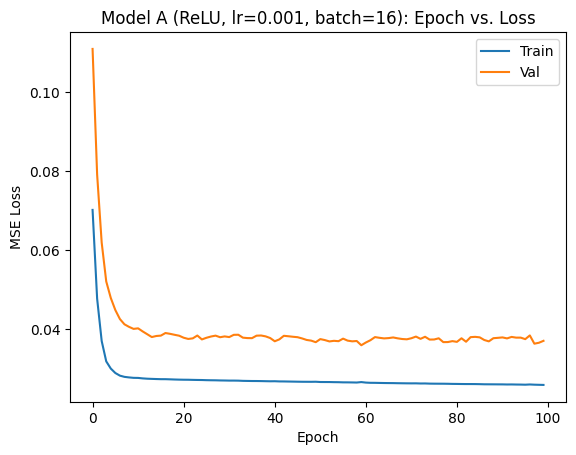

In [ ]:
# 1) Select the run you want to visualize
run = next(r for r in results
           if r['model']=='A'
           and r['activation']=='relu'
           and r['lr']==0.001
           and r['batch_size']==16)

train_hist = run['train_loss_hist']
val_hist   = run['val_loss_hist']

plt.plot(train_hist)
plt.plot(val_hist)
plt.title("Model A (ReLU, lr=0.001, batch=16): Epoch vs. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(["Train", "Val"])
plt.show()

Learning Rate vs. Final Loss A

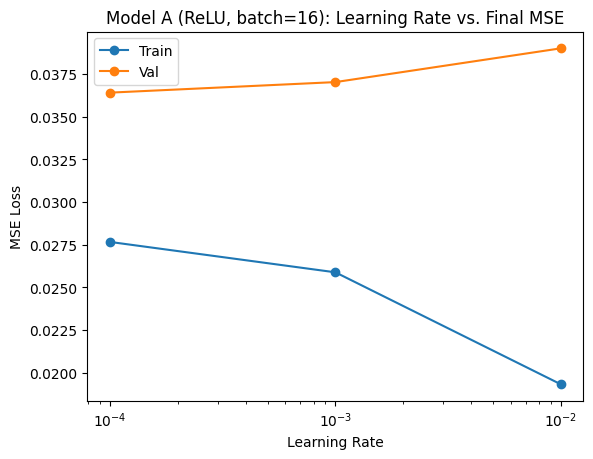

In [ ]:
# 2) Learning Rate vs. Final Loss (train & val) at fixed model A, ReLU, batch_size=16
lrs = [0.01, 0.001, 0.0001]
train_losses_lr = []
val_losses_lr   = []

for lr in lrs:
    run = next(r for r in results
               if r['model']=='A'
               and r['activation']=='relu'
               and r['lr']==lr
               and r['batch_size']==16)
    train_losses_lr.append(run['train_loss_hist'][-1])
    val_losses_lr.append(run['val_loss_hist'][-1])

plt.figure()
plt.plot(lrs, train_losses_lr, marker='o')
plt.plot(lrs, val_losses_lr,   marker='o')
plt.xscale('log')
plt.title("Model A (ReLU, batch=16): Learning Rate vs. Final MSE")
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.legend(["Train", "Val"])
plt.show()


Activation vs. Final Loss A

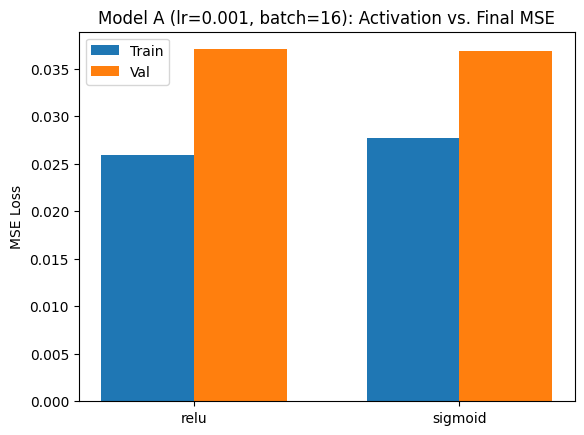

In [ ]:
# 3) Activation vs. Final Loss (train & val) at fixed model A, lr=0.001, batch_size=16
activations = ['relu', 'sigmoid']
train_losses_act = []
val_losses_act   = []

for act in activations:
    run = next(r for r in results
               if r['model']=='A'
               and r['activation']==act
               and r['lr']==0.001
               and r['batch_size']==16)
    train_losses_act.append(run['train_loss_hist'][-1])
    val_losses_act.append(run['val_loss_hist'][-1])

x = np.arange(len(activations))
width = 0.35

plt.figure()
plt.bar(x - width/2, train_losses_act, width, label='Train')
plt.bar(x + width/2, val_losses_act,   width, label='Val')
plt.xticks(x, activations)
plt.title("Model A (lr=0.001, batch=16): Activation vs. Final MSE")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


Batch Size vs. Average Epoch Time A

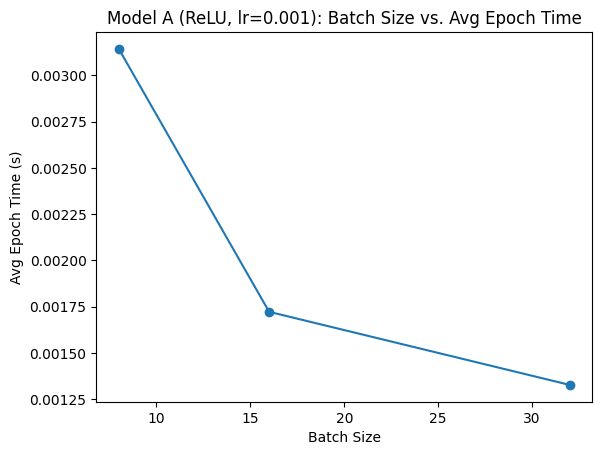

In [ ]:
# 4) Batch Size vs. Average Epoch Time at fixed model A, ReLU, lr=0.001
batch_sizes = [8, 16, 32]
epoch_times_mean = []

for bs in batch_sizes:
    run = next(r for r in results
               if r['model']=='A'
               and r['activation']=='relu'
               and r['lr']==0.001
               and r['batch_size']==bs)
    epoch_times_mean.append(np.mean(run['epoch_times']))

plt.figure()
plt.plot(batch_sizes, epoch_times_mean, marker='o')
plt.title("Model A (ReLU, lr=0.001): Batch Size vs. Avg Epoch Time")
plt.xlabel("Batch Size")
plt.ylabel("Avg Epoch Time (s)")
plt.show()


Epoch vs. Loss B

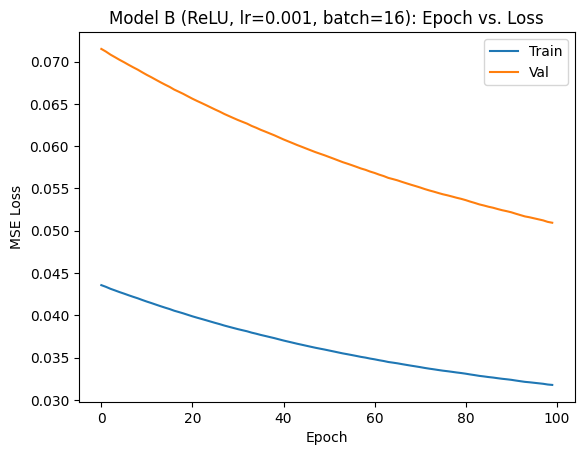

In [ ]:
# B1) Epoch vs. Loss (train & val) for Model B, ReLU, lr=0.001, batch_size=16
run_b = next(r for r in results
             if r['model']=='B'
             and r['activation']=='relu'
             and r['lr']==0.001
             and r['batch_size']==16)

plt.plot(run_b['train_loss_hist'])
plt.plot(run_b['val_loss_hist'])
plt.title("Model B (ReLU, lr=0.001, batch=16): Epoch vs. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(["Train", "Val"])
plt.show()


Learning Rate vs. Final Loss B

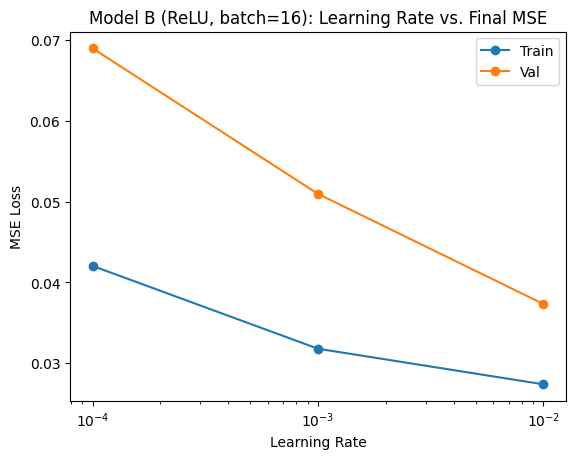

In [ ]:
# B2) Learning Rate vs. Final Loss (train & val) for Model B, ReLU, batch_size=16
lrs = [0.01, 0.001, 0.0001]
train_lr_b = []
val_lr_b   = []

for lr in lrs:
    run = next(r for r in results
               if r['model']=='B'
               and r['activation']=='relu'
               and r['lr']==lr
               and r['batch_size']==16)
    train_lr_b.append(run['train_loss_hist'][-1])
    val_lr_b.append(run['val_loss_hist'][-1])

plt.plot(lrs, train_lr_b, marker='o')
plt.plot(lrs, val_lr_b,   marker='o')
plt.xscale('log')
plt.title("Model B (ReLU, batch=16): Learning Rate vs. Final MSE")
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.legend(["Train", "Val"])
plt.show()


Activation vs. Final Loss B

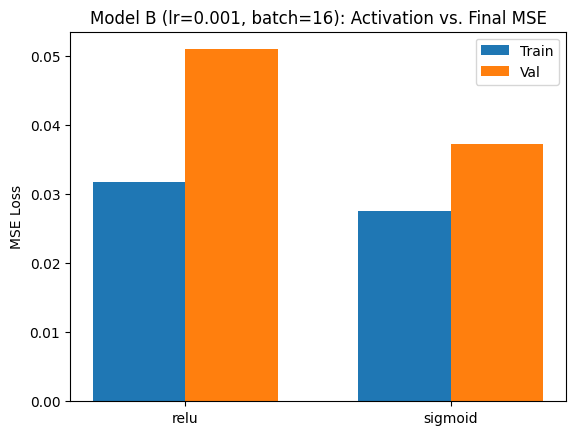

In [ ]:
# B3) Activation vs. Final Loss (train & val) for Model B, lr=0.001, batch_size=16
activs = ['relu', 'sigmoid']
train_act_b = []
val_act_b   = []

for act in activs:
    run = next(r for r in results
               if r['model']=='B'
               and r['activation']==act
               and r['lr']==0.001
               and r['batch_size']==16)
    train_act_b.append(run['train_loss_hist'][-1])
    val_act_b.append(run['val_loss_hist'][-1])

x = np.arange(len(activs))
width = 0.35

plt.bar(x - width/2, train_act_b, width, label='Train')
plt.bar(x + width/2, val_act_b,   width, label='Val')
plt.xticks(x, activs)
plt.title("Model B (lr=0.001, batch=16): Activation vs. Final MSE")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


Batch Size vs. Average Epoch Time B

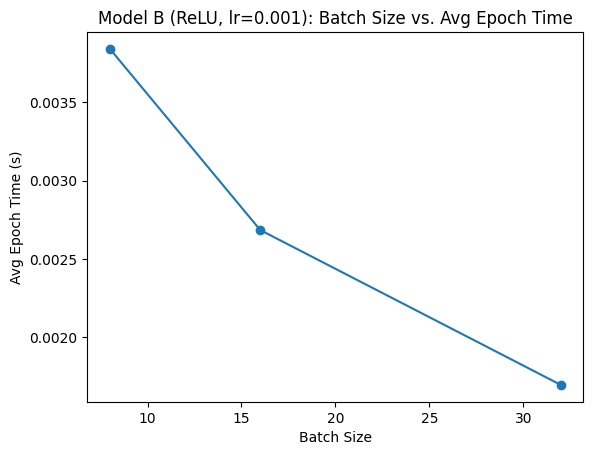

In [ ]:
# B4) Batch Size vs. Average Epoch Time for Model B, ReLU, lr=0.001
batches = [8, 16, 32]
times_b  = []

for bs in batches:
    run = next(r for r in results
               if r['model']=='B'
               and r['activation']=='relu'
               and r['lr']==0.001
               and r['batch_size']==bs)
    times_b.append(np.mean(run['epoch_times']))

plt.plot(batches, times_b, marker='o')
plt.title("Model B (ReLU, lr=0.001): Batch Size vs. Avg Epoch Time")
plt.xlabel("Batch Size")
plt.ylabel("Avg Epoch Time (s)")
plt.show()
